In [2]:
from torch.utils.data import DataLoader, random_split
# from utils.preprocess import FaceCompletionDataset
from utils.network_seq_contour import Parser
from utils.models import Generator, Discriminator
import torchvision.models as models
import torch
import copy
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import torch
import random
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor

class FaceCompletionDataset(Dataset):
    def __init__(self, image_dir, block_size=(64, 64)):
        self.image_dir = image_dir
        self.block_size = block_size
        self.image_list = os.listdir(image_dir)
        
    def __len__(self):
        return len(self.image_list)
    
    def random_block_mask(self, image, block_size=(64, 64)):
        h, w, _ = image.shape
        x = random.randint(0, w - block_size[0])
        y = random.randint(0, h - block_size[1])
        mask = np.zeros((h, w), dtype=np.uint8)
        mask[y:y + block_size[1], x:x + block_size[0]] = 1
        masked_image = image.copy()
        noise = np.random.randint(0, 256, size=(block_size[1], block_size[0], 3), dtype=np.uint8)
        masked_image[y:y + block_size[1], x:x + block_size[0]] = noise
        return masked_image, mask
    
    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.image_list[idx])
        image = cv2.imread(image_path)

        masked_image, mask = self.random_block_mask(image)
        #mask = np.expand_dims(mask, axis=0)
    
        image = ToTensor()(image)
        #mask = ToTensor()(mask)
        mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0) 
        masked_image = ToTensor()(masked_image)
 
        return image, mask, masked_image


image_dir = "preprocessed_images/"
save_path = './model_trained/'
celeba_dataset = FaceCompletionDataset(image_dir)


In [5]:
import joblib
val_dataset = joblib.load('val_dataset.pkl')
validation_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=4)

In [6]:
import torch
from utils.models import GatedGenerator, Generator, Discriminator

def load_checkpoint(generator, discriminator_local, discriminator_global, path, device):
    state = torch.load(path,map_location=device)
    generator.load_state_dict(state['G'])
    discriminator_global.load_state_dict(state['D_G'])
    discriminator_local.load_state_dict(state['D_L'])
    print('Loaded checkpoint successfully')
    return generator, discriminator_local, discriminator_global

device = 'cuda:2'
generator = GatedGenerator()
discriminator_global = Discriminator(in_channels=3)
discriminator_local = Discriminator(in_channels=3)

generator = generator.to(device)
discriminator_global = discriminator_global.to(device)
discriminator_local = discriminator_local.to(device)

generator, discriminator_local, discriminator_global = load_checkpoint(generator, discriminator_local, discriminator_global, "model_trained/model_7.pth", device)

Loaded checkpoint successfully


In [ ]:
def return_image_numpy(images, scale=False):
    if scale:
        completed_images_np = images[0].cpu().detach().numpy()
 
        completed_images_np = ((completed_images_np + 1) * 127.5)
        print(completed_images_np.shape)
        return completed_images_np.transpose(1, 2, 0)
    else:
        return images[0].detach().cpu().numpy().transpose(1, 2, 0)


Loaded checkpoint successfully


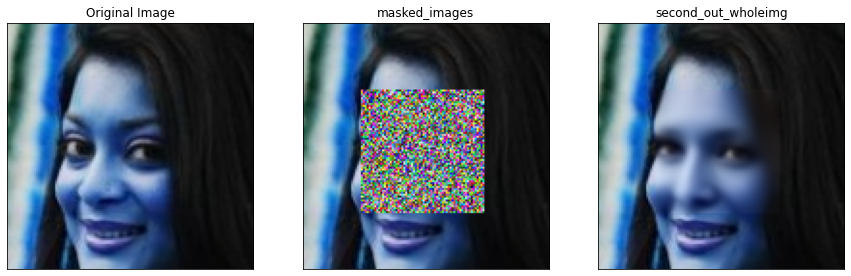

Loaded checkpoint successfully


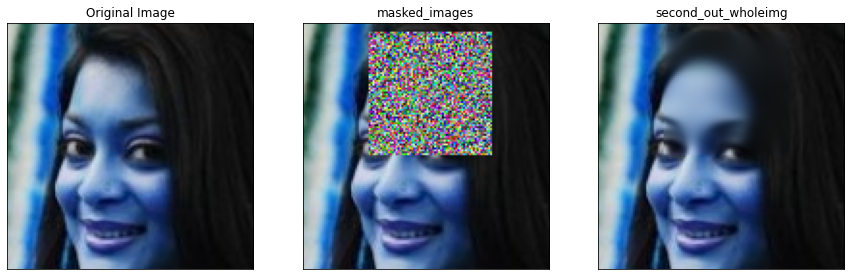

Loaded checkpoint successfully


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


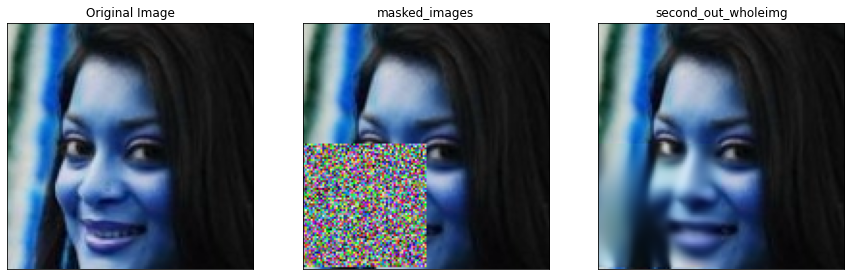

Loaded checkpoint successfully


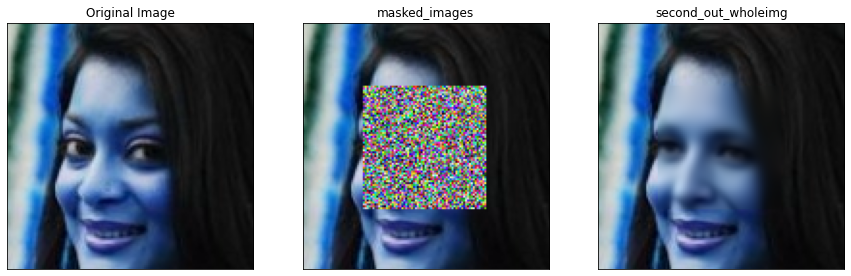

Loaded checkpoint successfully


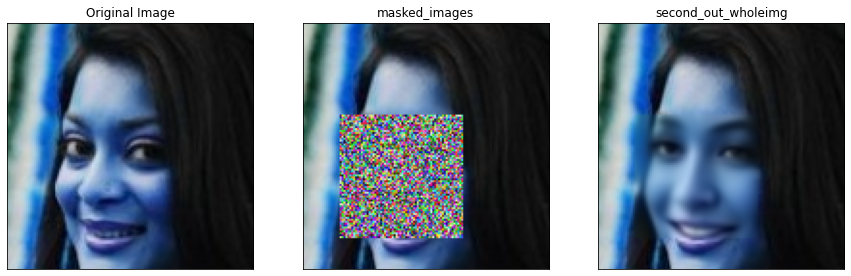

In [35]:
from utils.evaluate import evaluate_models, evaluate_model_external, SSIM
criterion_ssim = SSIM(window_size = 11)
result_df = pd.DataFrame(columns= ['epoch', 'val_psnr', 'val_ssim' ])

for ith_model in [0,1,2,3,4,7]:
    generator, discriminator_local, discriminator_global = load_checkpoint(generator, discriminator_local, discriminator_global, f"model_trained/model_{str(ith_model)}.pth", device)
    generator.eval()
    for i, (images, masks, masked_images) in enumerate(validation_dataloader):
        # Resize the images and masks to a consistent size

        images = images.to(device)
        masked_images = masked_images.to(device)
        masks = masks.to(device)
        first_out, second_out  = generator(images, masks)
        first_out_wholeimg = images * (1 - masks) + first_out * masks     
        second_out_wholeimg = images * (1 - masks) + second_out * masks
        if i == 0:
            fig, axs = plt.subplots(1, 3, figsize=(15, 5))
            axs[0].imshow(return_image_numpy(images))
            axs[0].set_title("Original Image")
            axs[1].imshow(return_image_numpy(masked_images))
            axs[1].set_title("masked_images")
            axs[2].imshow(return_image_numpy(second_out_wholeimg))
            axs[2].set_title("second_out_wholeimg")
            for ax in axs:
                ax.set_xticks([])
                ax.set_yticks([])

            plt.show()

    val_psnr, val_ssim = evaluate_model_external2(generator, validation_dataloader, device, criterion_ssim)
    
    if ith_model == 0:
        result_df = pd.DataFrame([{'epoch': ith_model, 'val_psnr': val_psnr, 'val_ssim': val_ssim}])
    else:
        aa = pd.DataFrame([{'epoch': ith_model, 'val_psnr': val_psnr, 'val_ssim': val_ssim}])
        result_df = pd.concat([result_df, aa], axis=0)
        result_df.to_csv('result_external.csv')     
        